# WIP So what's with __Goblins__ and how do they fight?

Here I delve into the numbers that describe an instance of a Goblin, what a population of Goblins within a tournament might look like and perhaps most importantly, the exact probabilistic functions that goblin populations are sampled from.

What makes this data unique is that unlike most 'real' datasets, the functions that describe goblins were defined manually and so are known. 

The numbers behind a goblin aim to give goblins a unique and somewhat interpretable personality and behaviours.

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import random

# local imports
from glicko_goblins.goblins import Fighter
from glicko_goblins.combat import Tournament
from glicko_goblins.configs import *

# nb configs
pd.set_option("display.max_columns", 500)
colour_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.style.use("fivethirtyeight")
font = {'family': 'serif', 'size': 12}
plt.rc('font', **font)

np.random.seed(42)
random.seed(42)

A Goblin's defining parameters can be categorised as follows:

----
1. __Base Stats__

    `max_hp, strength, cooldown, eagerness, lr`

    Goblin's engage in simulated battles within Tournaments. Battles are RPG/JRPG/Pokemon inspired, although rather than being turn-based, time runs linearly.
    
    Their objective is to defeat an opponent in a 1v1 by reducing their `max_hp` or Hit Points to 0. Their base stats determine some fundamental things about their performance within this framework. All base stats are integers, except lr or _learning rate_ which is a decimal value.

    Summaries:

    - __max_hp__: How much damage the Goblin can take from an opponent before losing the combat. Refreshed between combats.
    - __strength__: A factor in determining damage dealt per succseful swing.
    - __cooldown__: The delay between swings. Time in tournaments moves in seconds (realised as loop iterations). A cooldown of 7 means that a goblin will take a swing every 7 seconds. 
    - __eagerness__: Per tournament day, Goblins that are more _eager_ will likely compete in more combats.
    - __lr__: Learning rate contributes to how much a Goblin learns from a given combat, increasing its strength from one fight to the next. Some goblins are capable of learning much more from each combat than others.

----

2. __Base Probabilities__

    `guard_prob, guardbreak_prob, parry_prob, crit_prob, dodge_prob`

    When one Goblin swings at another, each has probabilities associated with the occurence of particular events. These determine which multipliers are applied during damage calculation and, in the case of `parry_prob`, who is going to sustain damage. I term these probabilities _specialisms_ below.

    Summaries:

    - __guard_prob__: The chance for the defending goblin to reduce the damage of an attack. Imagine a shield being raised or other deflection.
    - __guardbreak_prob__: Given that an opponent has guarded, the chance for the attacking Goblin to break through the guard and deal increased damage.
    - __parry_prob__: When an attacking Goblin swings, there is a chance that the defending Goblin counters; this represents that chance. A successful counter prevents the defending Golbin from taking damage and causes the attacking Goblin to take damage instead.
    - __crit_prob__: Prior to any of the above, each Goblin has the potential to supercharge a swing with a 'lucky strike'. Maybe their opponent slipped or the sun was in their eyes, or perhaps they just put a little extra force into a particular swing.
    - __dodge_prob__: Nimble goblins have a chance to completely avoid damage from a swing by dodging being struck altogether.

----

3. __Other Multipliers__
    
    `guts, avarice`

    - __guts__: The power increase of a goblin that is approaching defeat.
    - __avarice__: The degree to which a goblin is motivated by its funding. Some get cocky knowing they are a high paid fighter for example. 


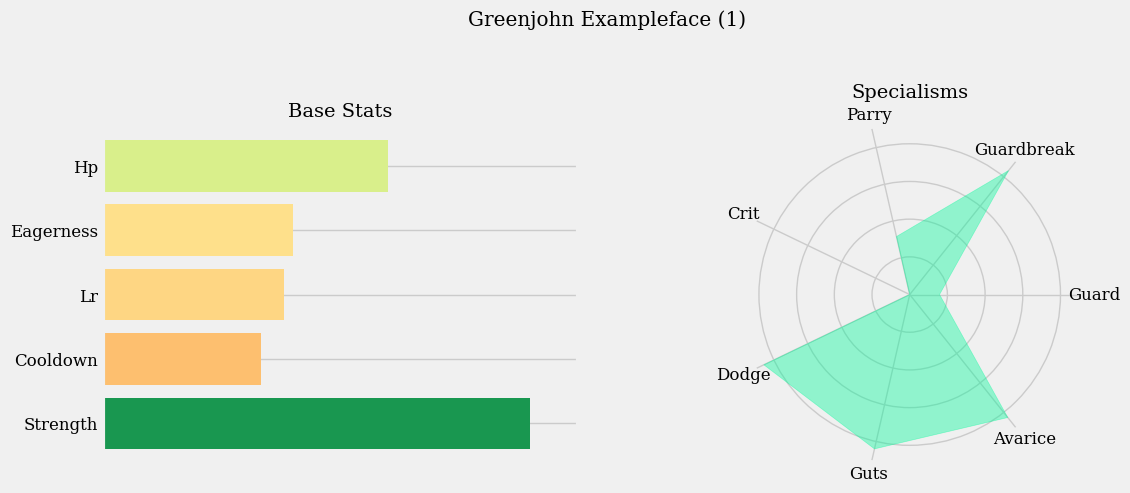

In [2]:
# initialise a random goblin
goblin = Fighter(name="Greenjohn Exampleface")
goblin.rating_deviation=350
goblin.tourn_id = 1
goblin.manager = "Mr Manager"

# visualise stats
fig = goblin.plot_base_stats()

The above bar chart normalizes stats so that 'how good' they are can be actively compared. 

The true stat values for this goblin are seen here:

In [3]:
# look at stats
all_stats = goblin.base_stats("bs")
all_stats.update(goblin.base_stats("bp"))
fnc = goblin._floors_and_ceilings()
floors, ceilings = fnc["floors"], fnc["ceilings"]

pd.DataFrame([{"name": k, "value": all_stats[k], "% of max":100*(all_stats[k] - floors[k])/ceilings[k],} for k in all_stats.keys()]).round(3).set_index("name")


,value,% of max
name,,
max_hp,36.000,26.667
strength,27.000,56.667
cooldown,6.000,55.556
lr,0.011,34.788
eagerness,2.000,20.000
guard_prob,0.142,15.828
guardbreak_prob,0.758,84.172
parry_prob,0.284,31.565
crit_prob,0.000,0.000


# Explanation of Stats
To best explain what each stat does, I describe the main function that uses them. When a stat appears in the function, I will do a distribution breakdown of that stat in a sample of goblins. Having been through the entire function I will describe the dependencies between stats, followed by a correlation analysis of stats with winrate and tournament ranking.

When two goblins are in combat, time passes in seconds. A goblin's `cooldown` is the number of seconds between `swing`s.

The most important function - a `swing` - is defined by the following function. The outcome of a swing is one of the two goblins taking damage, or nothing. 

```
def swing(self, target):

if target.does_parry():
    op_damage = int(1 + target.strength * COMBAT_MULTIPLIERS["parry"])
    self.current_hp -= op_damage
    return

if target.does_dodge():
    return 

effective_skill = np.max((self.skill - (self.time_since_last_combat * 0.1), 0.8))
effective_strength = (self.strength + self.cooldown)  * effective_skill
effective_strength += (effective_strength*self.avarice)

if self.does_crit():
    effective_strength *= COMBAT_MULTIPLIERS["crit"]

if target.does_guard():
    if self.does_break():
        damage = 1 + effective_strength * COMBAT_MULTIPLIERS["guardbreak"]
        
    else:
        damage = 1 + effective_strength * COMBAT_MULTIPLIERS["guard"]

else:
    damage = 1 + effective_strength * COMBAT_MULTIPLIERS["vanilla"]

damage = int(damage * np.random.uniform(0.9, 1, 1)[0])
target.current_hp -= damage
```

The first statement checks whether or not the swing is parried by the opponent. If parried, the attacking goblin does not deal any damage this swing and instead takes damage:
```
if target.does_parry():
    op_damage = int(1 + target.strength * COMBAT_MULTIPLIERS["parry"])
    self.current_hp -= op_damage
    return
```

The chance of this occurring is decided by the opponent's `parry_prob`. The `parry_prob`s of goblins are distributed as follows.

In [4]:
examples = [Fighter() for _ in range(30_000)]
print(f"Minimum Parry Chance: {floors['parry_prob']}\nMaximum Parry Chance: {ceilings['parry_prob']}")

Minimum Parry Chance: 0.0
Maximum Parry Chance: 0.9


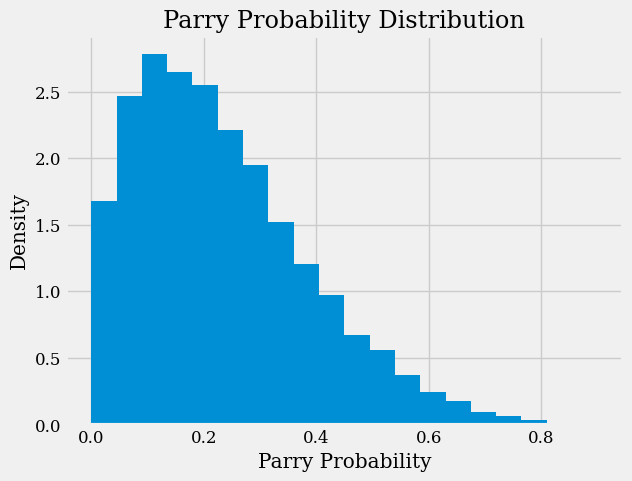

In [5]:
plt.hist([f.parry_prob for f in examples], density=True, bins=20)
plt.xlabel("Parry Probability")
plt.ylabel("Density")
_ = plt.title("Parry Probability Distribution")

The damage of a parry is simply a function of `strength` of the goblin doing the parying and the parry multiplier constant of `0.5`. This is twice the vanilla hit multiplier of `0.25`.

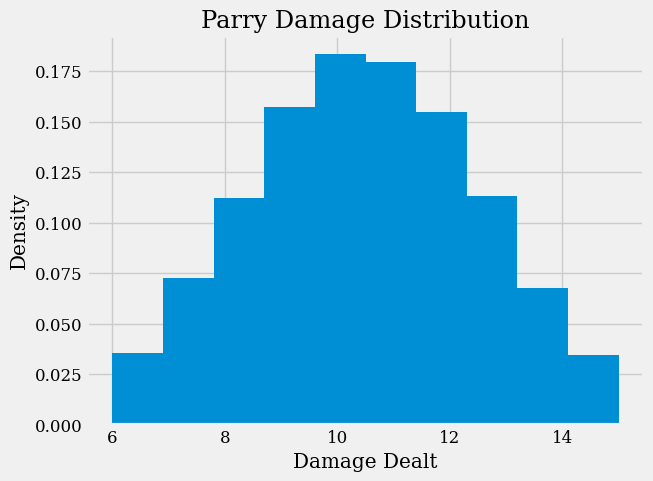

In [6]:
plt.hist([int(1 + f.strength * COMBAT_MULTIPLIERS["parry"]) for f in examples], density=True, bins=10)
plt.xlabel("Damage Dealt")
plt.ylabel("Density")
_ = plt.title("Parry Damage Distribution")

If a parry does not occur, a `dodge` is checked for using: 

```
if target.does_dodge():
    return 
```

Dodges result in the target taking 0 damage and the chance of one occurring depends on the opponent's `dodge_prob`, which is distributed as follows:

Minimum Dodge Chance: 0
Maximum Dodge Chance: 0.04


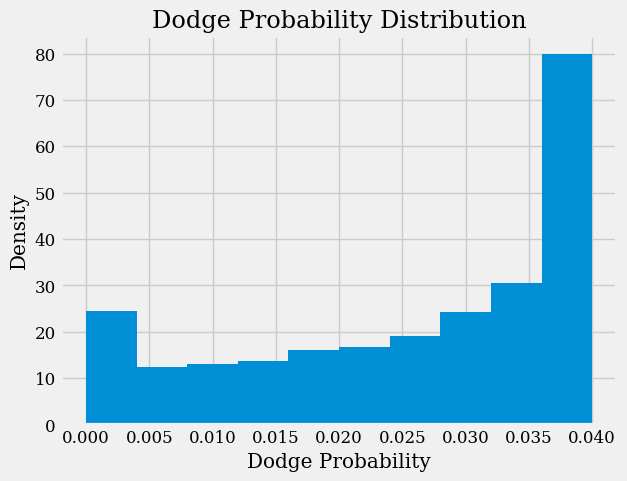

In [7]:
plt.hist([f.dodge_prob for f in examples], density=True)
plt.xlabel("Dodge Probability")
plt.ylabel("Density")
plt.title("Dodge Probability Distribution")

print(f"Minimum Dodge Chance: {floors['dodge_prob']}\nMaximum Dodge Chance: {ceilings['dodge_prob']}")

If the swing makes it past the previous checks, it is guaranteed to do at least 1 damage. How much it actually does depends on multiple factors.

The first factor is calculating the `effective_strength` of a goblin, which can be understood as their `strength` in context.

It is derived using the following calculation:

```
effective_skill = np.max((self.skill - (self.time_since_last_combat * 0.1), 0.8))
effective_strength = (self.strength + self.cooldown)  * effective_skill
effective_strength += (effective_strength*self.avarice)
```

As you can see, `effective_strength` is the sum of `strength` and `cooldown` with some mulitpliers applied.

The first multiplier is `effective_skill` and is determined by the goblin's previous combats and opponents. We will take this to be the base value of `1` for now.

This leaves `effective_strength` as being a multiple of `avarice`, which is a measure of how much a goblin's performance is affected by its `funding`.

Minimum Strength: 10
Maximum Strength: 30


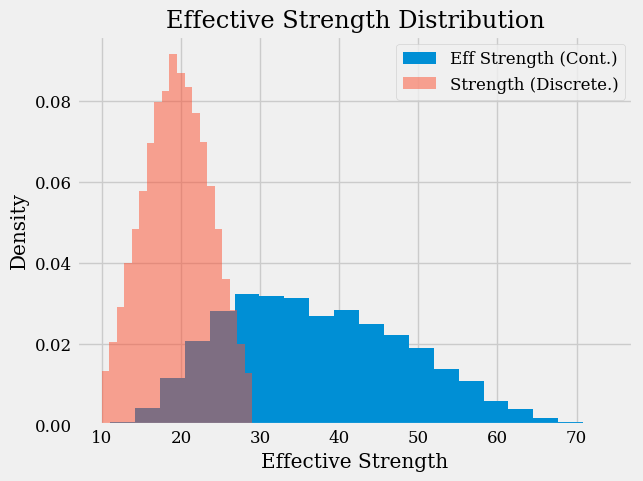

In [8]:
plt.hist([(f.strength + f.cooldown) + ((f.strength + f.cooldown) * f.avarice) for f in examples], density=True, bins=20)
plt.xlabel("Effective Strength")
plt.ylabel("Density")
plt.title("Effective Strength Distribution")
plt.hist([f.strength for f in examples], density=True, bins=20, alpha=0.5)
_ = plt.legend({"Eff Strength (Cont.)": "blue", "Strength (Discrete.)": "red"})

print(f"Minimum Strength: {floors['strength']}\nMaximum Strength: {ceilings['strength']}")

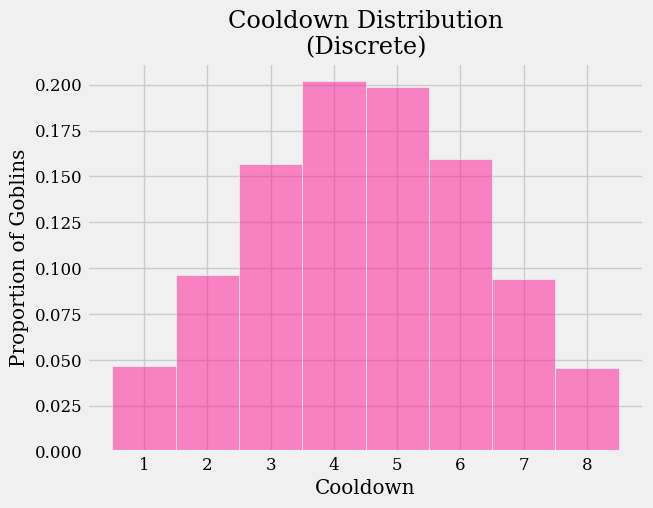

In [9]:
sns.histplot([f.cooldown for f in examples], bins=8, discrete=True, stat="proportion", color="deeppink", alpha=0.5)
plt.xlabel("Cooldown")
plt.ylabel("Proportion of Goblins")
_ = plt.title("Cooldown Distribution\n(Discrete)")

Above we see that the `strength` observable with `goblin.plot_base_stats()` - whilst a sensible estimate of strength - is not a direct descriptor of contextual strength and initial amount of damage to be dealt. Based on the max raw `strength` of `30`, `cooldown` can contribute a 3 to 27% increase in `strength` at the cost of `swing` frequency.

Complexity enters the mix further here since the subsequent multiplying factors, `avarice` and `skill` are not static values. They introduce a contextual variable in which the `effective_strength` of a goblin varies based on how much money they are receiving and their combat history (e.g. some goblins who lose to very high rated opponents 'learn a lot' from those losses and thus hit harder in subsequent combats).

Below is an initial avarice plot. An avarice of 1 translates to an increase in effective_strength of 100%.

0

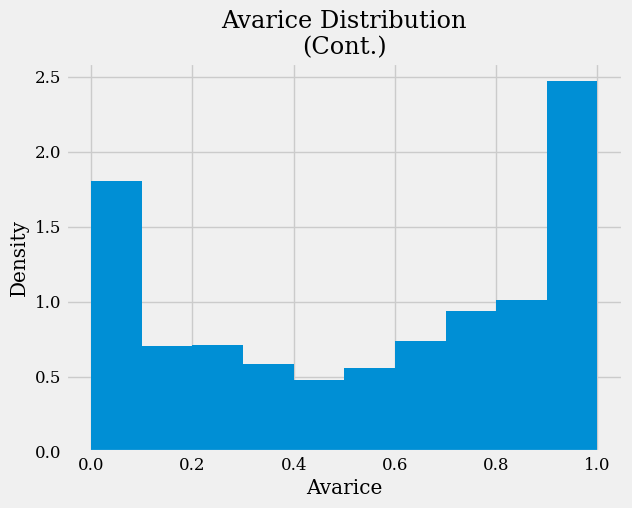

In [10]:
plt.hist([f.avarice for f in examples], density=True)
plt.xlabel("Avarice")
plt.ylabel("Density")
_ = plt.title("Avarice Distribution\n(Cont.)")

floors["avarice"]

As a reminder, we looked at `strength`, `cooldown` and `avarice` here to help understand `effective_strength` which is a precursor to the damage of a `swing`:

```
effective_skill = np.max((self.skill - (self.time_since_last_combat * 0.1), 0.8))
effective_strength = (self.strength + self.cooldown)  * effective_skill
effective_strength += (effective_strength*self.avarice)
```

Following this calculation, we check for a critical hit using the following:

```
if self.does_crit():
    effective_strength *= COMBAT_MULTIPLIERS["crit"]
```

where the crit multiplier is `4`, or `16` times that of a vanilla swing.

Unlike `parry_prob` and `dodge_prob`, `crit_prob` is not used in isolation to determine the chance of the swing being critical. 
When a goblin has max_hp, the chance of a crit is simply `crit_prob` and is distributed like so:


Minimum Crit Chance: 0.0001
Maximum Crit Chance: 0.45


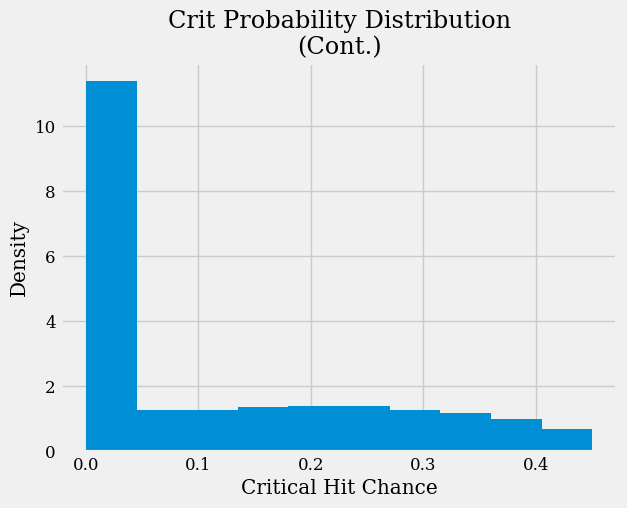

In [11]:
plt.hist([f.crit_prob for f in examples], density=True)
plt.xlabel("Critical Hit Chance")
plt.ylabel("Density")
_ = plt.title("Crit Probability Distribution\n(Cont.)")
print(f"Minimum Crit Chance: {floors['crit_prob']}\nMaximum Crit Chance: {ceilings['crit_prob']}")

Most Goblins have a 1 in 10,000 chance to land a critical hit at max health. This isn't the full picture however, as the `guts` stat also impacts crit chance. 

As goblin health gets lower during a combat, `crit_prob` increases proportionally to % missing health at a rate of `guts`. Like `avarice` and `skill`, `guts` itself depends on pseudo-real-time factors like the `rating_deviation` of the goblin which in this example is constant. With constant `rating_deviation` we observe `guts` as a uniform distribution.

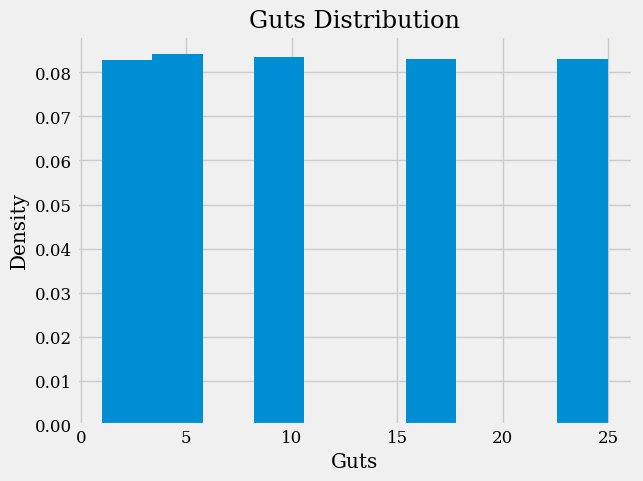

In [12]:
plt.hist([f.guts for f in examples], density=True)
plt.xlabel("Guts")
plt.ylabel("Density")
_ = plt.title("Guts Distribution")

Having determined the `effective_strength` of the `swing` and whether it crits, we now calculate the damage itself. 

```
if target.does_guard():
    if self.does_break():
        damage = 1 + effective_strength * COMBAT_MULTIPLIERS["guardbreak"]
        
    else:
        damage = 1 + effective_strength * COMBAT_MULTIPLIERS["guard"]

else:
    damage = 1 + effective_strength * COMBAT_MULTIPLIERS["vanilla"]

```

The first check is whether or not the target guards. A succesful guard depends on `guard_prob` and applies a `1/10` multiplier to the damage. `guard_prob` is distributed in goblins as a clipped gaussian as seen below:

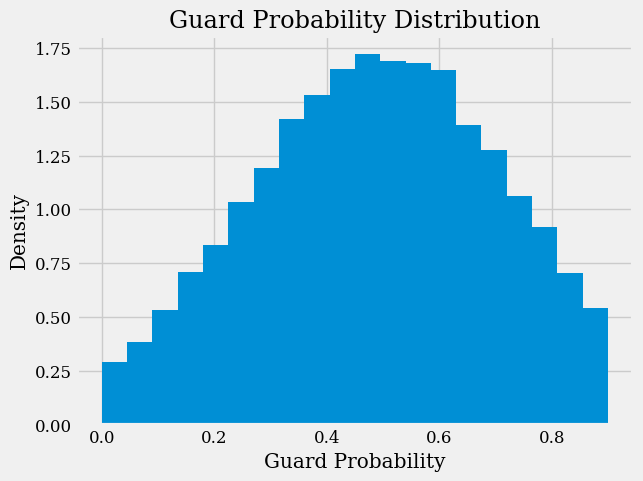

In [13]:
plt.hist([f.guard_prob for f in examples], density=True, bins=20)
plt.xlabel("Guard Probability")
plt.ylabel("Density")
_ = plt.title("Guard Probability Distribution")

In opposition to `guard_prob` is `guardbreak_prob`; the chance that, given a successful guard from the opponent, the swinging goblin smashes through the guard anyway. A broken guard uses a `1/3` multiplier as opposed to `1/10` for a succseful guard and `1/4` for a vanilla hit.

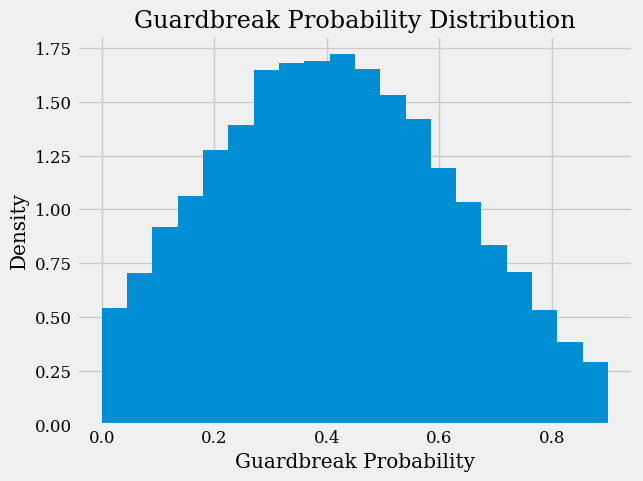

In [14]:
plt.hist([f.guardbreak_prob for f in examples], density=True, bins=20)
plt.xlabel("Guardbreak Probability")
plt.ylabel("Density")
_ = plt.title("Guardbreak Probability Distribution")

Finally, the damage value is multiplied by a value sampled from a uniform distribution between 0.9 and 1 such that there is random variance between hits. Then the decimal is dropped to give damage in an integer value.

# Skill, Avarice and Guts

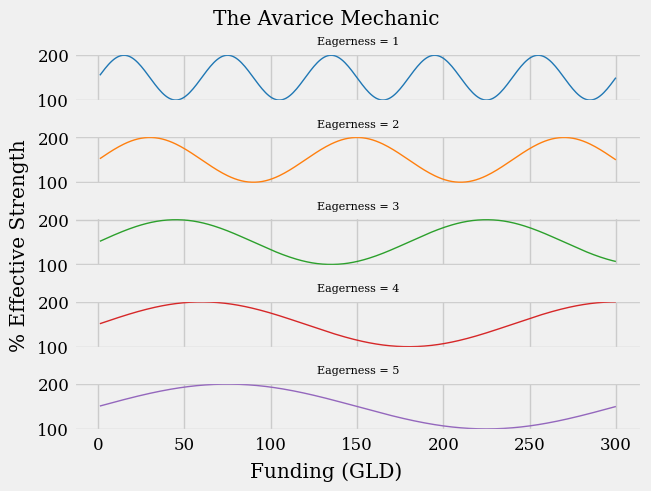

In [15]:
max_funding = STAT_DISTRIBUTIONS["funding"][3]
fig, ax = plt.subplots(nrows=MAX_EAGERNESS, sharex=True, sharey=True, constrained_layout=True)

fig.suptitle("The Avarice Mechanic")
fig.supxlabel("Funding (GLD)")
fig.supylabel("% Effective Strength")

for j in range(MAX_EAGERNESS):
    avarices = []
    for i in range(1, max_funding + 1):
        g = Fighter()
        av = g._generate_avarice(funding=i, max_funding=max_funding, eagerness=j+1)
        avarices.append(100 + (av*100))


    ax[j].plot(range(1, max_funding +1), avarices, color=colour_pal[j], lw=1)
    ax[j].set_title(f"Eagerness = {j+1}", fontdict={"fontsize": 8})



Avarice maps a goblin's money-drive to their in combat performance. Through use of the sine function, I aim to emulate sensitivity to change in funding. Goblins that aren't eager to fight are more sensitive to small fluctuations in funding whereas goblins that were likely to fight a lot anyway are not. 

The inutition behind performance decreasing as funding increases in some instances is the notion of cockiness or complacency in overpaid goblins. Likewise, goblins that feel underpaid may have little drive to perform well, but some goblins might 'not be in it for the money' in the first place.

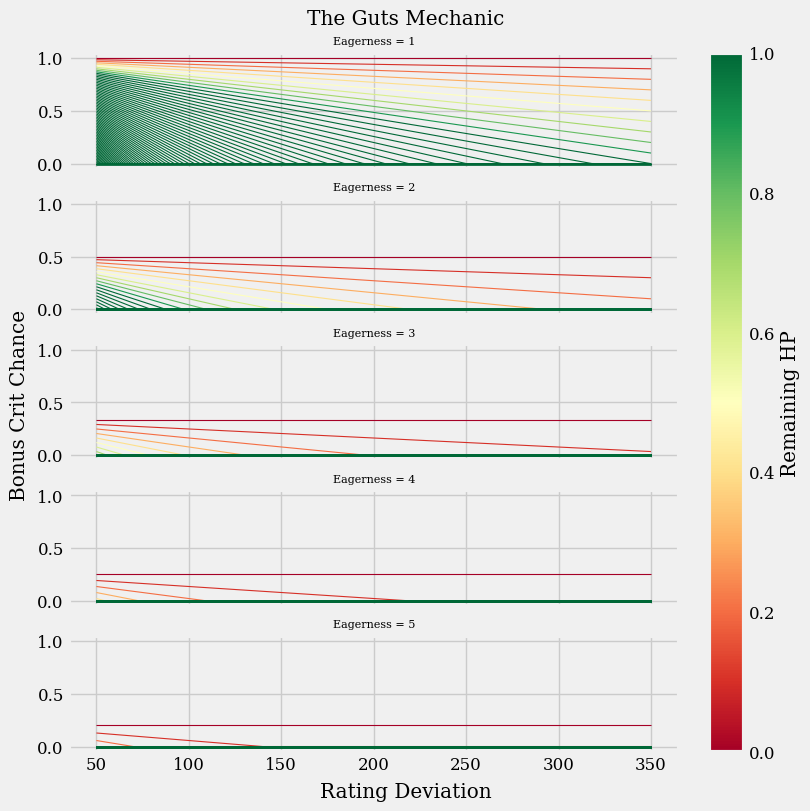

In [16]:
colors = [plt.cm.RdYlGn(k*0.1) for k in range(0,101)]
max_funding = STAT_DISTRIBUTIONS["funding"][3]
rating_deviation_range = range(50, 350+1)
fig, ax = plt.subplots(nrows=MAX_EAGERNESS, sharex=True, sharey=True, constrained_layout=True, figsize=(8,8))

fig.suptitle("The Guts Mechanic")
fig.supxlabel("Rating Deviation")
fig.supylabel("Bonus Crit Chance")

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=None, cmap=plt.cm.RdYlGn), ax=ax)
cbar.set_label('Remaining HP')

for j in range(MAX_EAGERNESS):
    for health in range(0,101):
        colour_k = health
        health*=0.1
        crits = []
        eagerness = j + 1
        for i in rating_deviation_range:
            rd = i
            gt = (eagerness**2) * (rd/350)
            crit = (1 - (health * gt)) / eagerness
            if crit < 0:
                crit = 0
            crits.append(crit)
        ax[j].plot(rating_deviation_range, crits, color=colors[colour_k], lw=0.8)

    ax[j].set_title(f"Eagerness = {j+1}", fontdict={"fontsize": 8})


Rating Deviation by nature decreases with number of games played. If we imagine a goblin is aware of its rating deviation - or the confidence in its rating value - we can use this as a proxy for how comfortable a goblin is within its skill bracket.The more confident a goblin, the more ballsy they will be.

Combining this with the goblin's base eagerness to fight, we get guts, which can be holistically interpreted as 'drive to keep fighting when HP is low' and is realised mechanically as an increase in the chance to land a critical hit. Goblins with low base eagerness have more guts; they generally fight less and therefore have more gusto to make it through a given fight.


# Damage as a Concept

In [17]:
simulation = pd.read_hdf("_dev_notebooks/tournament_simulations_3000.hdf").drop(["alive", "pep"], axis=1)
simulation["did_profit"] = (simulation["earnings"] > simulation["funding"]).map(int)
simulation["return"] = simulation["earnings"]/simulation["funding"]
sim_end = simulation.query("round == 6")
sim_end

,tourn_id,earnings,tournament_name,rating,rating_deviation,mean_outcome,max_hp,current_hp,strength,cooldown,lr,eagerness,funding,guard_prob,guardbreak_prob,parry_prob,crit_prob,dodge_prob,guts,avarice,skill,wins,total_games,recent_winloss,entry_day,time_since_last_combat,swings,guards_broken,successful_guards,failed_guards,attacks_parried,times_parried_by_opponent,critical_hits,attacks_dodged,round,mean_damage,max_damage,did_profit,return
0,0,28,0,1310.072611,119.789187,0.300210,36,36,27,6,0.011437,2,46,0.142449,0.757551,0.284082,0.000100,0.034363,1.369019,0.834565,1.034930,6,15,0.000000,0,0,20,8,1,1,8,4,0,1,6,16.166667,21.0,0,0.608696
1,1,196,0,1662.953468,116.669540,0.656037,51,51,21,6,0.002044,2,168,0.804672,0.095328,0.035748,0.378504,0.031582,1.333366,0.793893,1.004263,10,14,2.000000,0,0,35,3,33,17,2,3,17,2,6,19.794118,65.0,1,1.166667
2,2,4,0,1355.899557,89.410080,0.340998,20,20,29,5,0.011601,5,104,0.362671,0.537329,0.268664,0.000100,0.039551,6.386434,0.910575,1.091985,11,33,1.500000,0,0,54,10,17,8,16,10,0,4,6,14.866667,22.0,0,0.038462
3,3,58,0,1458.805124,103.608784,0.447349,43,43,14,3,0.008592,3,94,0.868450,0.031550,0.023663,0.402674,0.024095,2.664226,0.430413,1.026935,8,19,0.500000,0,0,82,3,32,21,4,23,24,2,6,9.666667,29.0,0,0.617021
4,4,207,0,1660.008830,121.133634,0.652817,39,39,25,5,0.009627,2,252,0.840654,0.059346,0.029673,0.390654,0.037197,1.384384,0.793893,1.023074,9,14,2.000000,0,0,34,1,13,10,1,8,11,1,6,21.444444,55.0,0,0.821429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,65,481,3999,1641.265527,112.374881,0.625848,43,43,13,3,0.015905,3,265,0.278695,0.621305,0.465979,0.000100,0.020783,2.889640,0.586824,1.081217,15,20,2.000000,0,0,105,27,4,2,29,11,2,0,6,6.837398,35.0,1,1.815094
66,66,0,3999,1342.294020,92.359455,0.318357,31,31,21,4,0.002625,5,191,0.384244,0.515756,0.322348,0.000100,0.026779,6.597104,0.121502,1.030245,9,33,0.666667,0,0,100,25,25,13,40,21,0,1,6,7.974790,11.0,0,0.000000
67,67,1,3999,1260.222795,100.841229,0.245148,35,35,23,6,0.012567,3,126,0.360973,0.539027,0.202135,0.045730,0.038819,2.593060,0.024472,1.051143,6,22,0.500000,0,0,68,16,19,7,12,13,2,1,6,8.417910,41.0,0,0.007937
68,68,10,3999,1346.090289,85.656672,0.321485,22,22,15,3,0.016588,5,163,0.485241,0.414759,0.311069,0.000100,0.001901,6.118334,0.365540,1.112526,12,34,0.666667,0,0,124,14,18,6,43,23,0,0,6,6.215278,9.0,0,0.061350


In [18]:
sim_end.total_games.sum()

5766176

<Axes: title={'center': 'Expected Damage of Swing compared to Goblin HP'}, xlabel='Hit Points', ylabel='Density'>

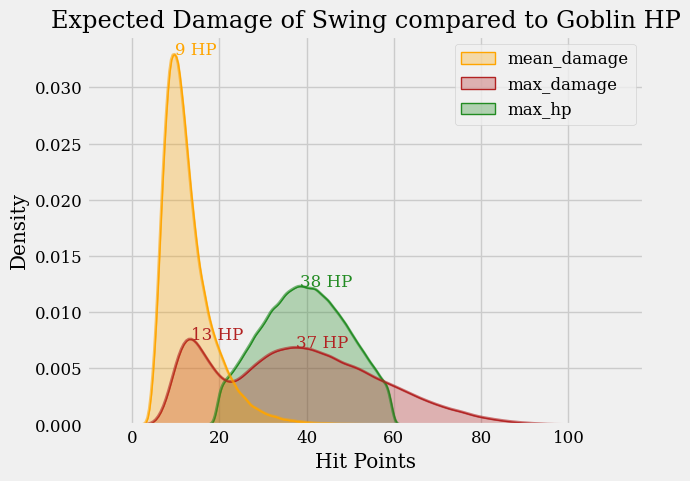

In [19]:
from scipy.signal import find_peaks

plot_foci = ["mean_damage", "max_damage", "max_hp"]
stat_palette = ["orange", "firebrick", "forestgreen"]
ax = sns.kdeplot(sim_end[plot_foci], alpha=0.6, fill=False, palette=stat_palette, lw=2)

for i in range(len(ax.lines)):
    x = ax.lines[i].get_xdata()
    y = ax.lines[i].get_ydata()
    for peak in find_peaks(y, prominence=0.001)[0]:
        maxid=peak
        plt.text(x[maxid],y[maxid], f"{int(x[maxid])} HP", c=stat_palette[::-1][i])

plt.xlabel("Hit Points")
plt.title("Expected Damage of Swing compared to Goblin HP")

# plotting again over the top because otherwise can't fill them due to awkward ax.lines properties in kde plot
sns.kdeplot(sim_end[plot_foci], alpha=0.3, fill=True, palette=stat_palette, lw=1)

What can be gleaned from this?

The most typical goblin hitting another typical goblin can reasonably expect to defeat their opponent in 5 hits. (Comparing the peak of mean_damage to the peak of max_hp)

Particularly strong goblins are capable of defeating particularly weak goblins in a single hit. (Comparing the intersection of tails between mean_damage and max_hp)

Particularly strong goblins that get lucky are capable of defeating even the strongest possible goblins in a single hit. (Comparing the upper bound of max_hp to the tail of max_damage)

A typical strongest hit is probably not quite enough to defeat the average goblin in a single hit. (Comparing the second peak of max_damage to the peak of max_hp)

C:\Users\User\AppData\Local\Temp\ipykernel_12724\2416459358.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.abs(ax.get_yticks()))


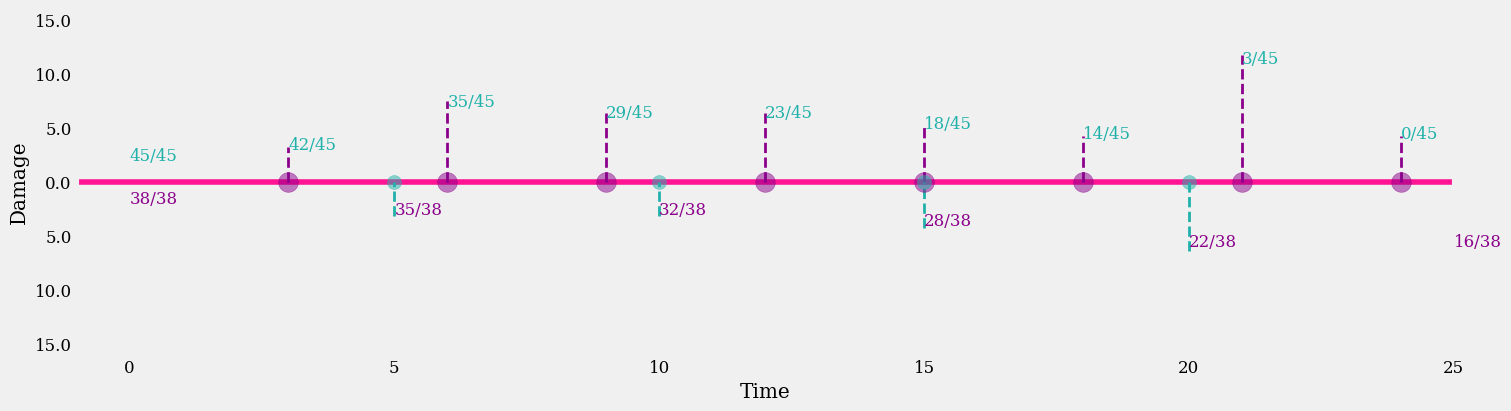

In [20]:
# grotesque but does the job xd. Hindsight wouldve zipped them
timesa = [3*i for i in range(30//3)]
timesb = [5*i for i in range(30//5)]
damagesa = [random.randint(3,12) for _ in range(len(timesa))]
damagesb = [random.randint(3,12) for _ in range(len(timesb))]

max_time = max(timesa + timesb)
fig, ax = plt.subplots(figsize=(15, 4), constrained_layout=True)

ca = "darkmagenta"
cb = "lightseagreen"

hpa = 38
hpb = 45

max_hpa = hpa
max_hpb = hpb

max_time = 0

for d,t in zip(damagesa, timesa):
    if t > max_time:
        max_time = t
    if t !=0:
        ymin=0.5
        ymax=0.5 + 0.5*(d/15)
        ax.axvline(x=t, ymin=ymin, ymax=ymax, c=ca, lw=2, linestyle="--")

        hpb -= d
        if hpb <= 0:
            hpb = 0
        ax.text(x=t, y=d, s=f"{hpb}/{max_hpb}", c=cb)
        if hpb == 0:
            break
    else:
        plt.text(x=t, y=2, s=f"{hpb}/{max_hpb}", c=cb)


for d,t in zip(damagesb, timesb):

    if t !=0:
        ymin=0.5 - 0.5*(d/15)
        ymax=0.5

        ax.axvline(x=t, ymax=ymax, ymin=ymin, c=cb, lw=2, linestyle="--")
        hpa -= d
        if hpa <= 0:
            hpa = 0
        plt.text(x=t, y=-d, s=f"{hpa}/{max_hpa}", c=ca)

        if hpa == 0:
            break
    else:
        plt.text(x=t, y=-2, s=f"{hpa}/{max_hpa}", c=ca)


_ = ax.set_ylim(-16, 16)
_ = ax.set_xlim(-1, max_time+1)
_ = ax.axhline(0, xmin=0, xmax=max_time, c='deeppink', zorder=1)
 
ac_a = [t for t in timesa if t <= max_time]
ac_b = [t for t in timesb if t <= max_time]

_ = ax.scatter(ac_a[1:], np.zeros(len(ac_a)-1), s=200, c=ca, zorder=2,alpha=0.5)
_ = ax.scatter(ac_b[1:], np.zeros(len(ac_b)-1), s=100, c=cb, zorder=3, alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Damage")
ax.set_yticklabels(np.abs(ax.get_yticks()))
#plt.title("Example Combat")
plt.grid(False)

Text(0.5, 0, 'LR')

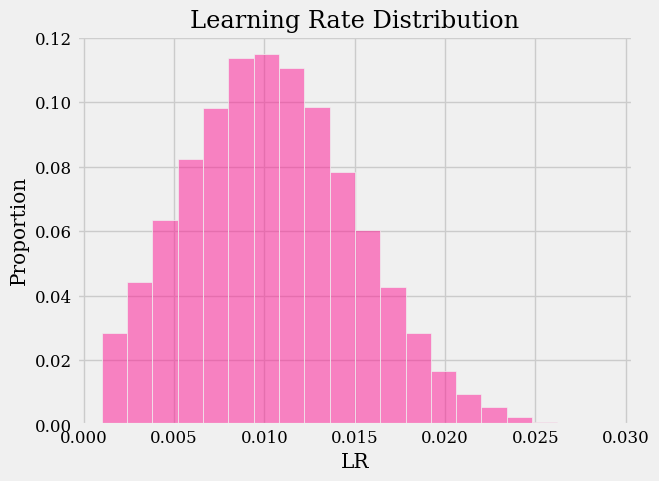

In [21]:
sns.histplot([f.lr for f in examples], stat="proportion", color="deeppink", alpha=0.5, bins=20)
plt.title("Learning Rate Distribution")
plt.xlabel("LR")

In [447]:
from glicko_goblins.glicko import game_outcome
from scipy.stats import beta

def learn_from_experience(actual_outcome: int, skill:float, lr:float, rating:int, rd:int, opponent_rating:int, opponent_rd:int):
        """
        Use Glicko's expected game outcome to scale self.skill by beating opponents against the odds.
        Approximates "learning" from harder games.
        game_outcome() is closer to 1 the more the opponent is expected to win based on rating and rating deviation.
        """
        expected_outcome = game_outcome(rating, opponent_rating, rd, opponent_rd)
        if actual_outcome == 0:
                base = lr
                if expected_outcome > 0.5:
                        disparity = lr - np.sin(2*np.pi*expected_outcome)
                elif expected_outcome <= 0.5:
                        disparity = lr + (1.5 * beta.pdf(1.5*expected_outcome, 2, 4))
        elif actual_outcome == 1:
                disparity = beta.pdf(expected_outcome, 2, 4)
        
        skill += lr * disparity

        return skill

In [448]:
STAT_DISTRIBUTIONS["lr"]

(0.01, 0.005, 0.001, 0.03)

In [504]:
a = list(range(1100, 2000, 10))
b = a[::-1]
rds = list(range(50,350,10))
skill = 10
skills = []
for lr in range(0,31,5):
    if lr == 0:
        continue
    lr*=0.001
    for result in [0,1]:
        res_to_str = lambda r: "Win" if r else "Loss"
        result_str = res_to_str(result)
        for ai, bi in zip(a,b):
            for rd, rdo in zip(rds, rds[::-1]):
                new_skill = learn_from_experience(
                                    actual_outcome=result,
                                    skill=skill,
                                    lr=lr,
                                    rating=ai,
                                    rd=rd,
                                    opponent_rating=bi,
                                    opponent_rd=rdo,
                                    )
                
                skills.append({"Change in Skill":new_skill-skill,
                            "rating": ai,
                            "rd": rd,
                            "op_rating": bi,
                            "op_rd": rdo,
                            "Expected Game Outcome":game_outcome(ai,bi,rd,rdo),
                            "absolute_rating_diff": abs(ai-bi),
                            "Game Outcome": result_str,
                            "Learning Rate": lr,
                            })


skill_df = pd.DataFrame(skills)   


(0.0, 0.1)

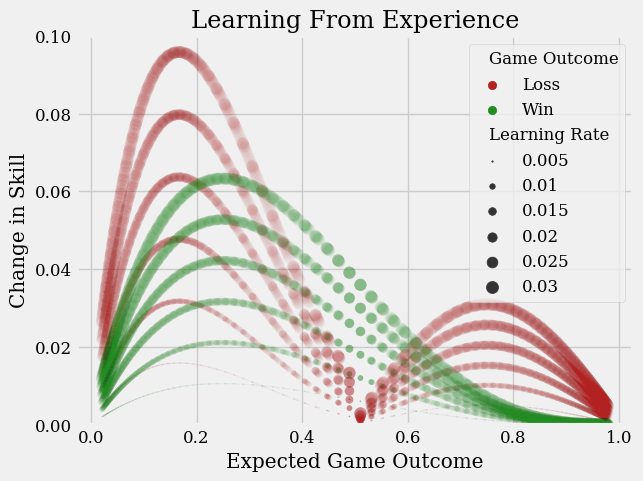

In [507]:
sns.scatterplot(skill_df, y="Change in Skill", x="Expected Game Outcome", hue="Game Outcome", size="Learning Rate", sizes=(1,75), alpha=0.02, palette=["firebrick", "forestgreen"],)
plt.title(f"Learning From Experience")
plt.ylim((0,0.10))

This comes from 1v1 game experience and intuition:
- Losing to someone who is incomprehensibly better than you does not allow you to learn, because you don't know why you lost
- Losing to someone sligtly better than you is the sweet spot
- Generally playing against players much worse than you reinforces bad habits
- Playing against players around your level doesn't do too much
- Winning against players much better than you allows for some good learning
- Sometimes luck is the deciding factor

In [228]:
skill_df

,new_skill,rating,rd,op_rating,op_rd,expected_outcome,absolute_rating_diff,result
0,2.031594,1100,50,1990,340,0.030403,890,0
1,2.031607,1100,60,1990,330,0.029091,890,0
2,2.031617,1100,70,1990,320,0.027877,890,0
3,2.031625,1100,80,1990,310,0.026761,890,0
4,2.031632,1100,90,1990,300,0.025743,890,0
...,...,...,...,...,...,...,...,...
5395,2.012396,1990,300,1100,90,0.974257,890,1
5396,2.012388,1990,310,1100,80,0.973239,890,1
5397,2.012379,1990,320,1100,70,0.972123,890,1
5398,2.012368,1990,330,1100,60,0.970909,890,1
